# Lab 6 : Neural Networks

<div class="alert alert-block alert-danger">

__IMPORTANT__ 
Please complete this Jupyter Notebook file and upload it to blackboard __before 8 March 2020__ evening.
</div>

Classifiers such as logistic regression cannot directly form more complex hypotheses as it is only a linear classifier. In this Lab, you will implement a neural network from scrach to recognize handwritten digits. The neural network will be able to result in a complex model that forms a non-linear hypotheses.

To start, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our provided weights for prediction. Then, you will implement the backpropagation algorithm for learning the neural network parameters (i.e. weights) and apply it to the task of hand-written digit recognition.

Before starting this Lab, we strongly recommend reading the slides of lecture 6.

# 1. Dataset and Visualization
For this Lab, you will use a dataset to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks automatically. This Lab will show you how the methods you've learned can be used for this classification task.

You are given a data set in `digits-dataset.mat` that contains $n = 5000$ training examples of handwritten digits. Each training example is a vector in $\mathbb{R}^d$ where $d=400$, resulting from a 20 pixel by 20 pixel grayscale image of the digit. In order words, each pixel is represented by a floating point number indicating the grayscale intensity at that location; the 20 by 20 grid of pixels was "*unrolled*" (i.e. flattened) into a 400-dimensional vector. So, each of these training examples becomes a single row in our data matrix $X$. This gives us a $5000 \times 400$ matrix $X \in \mathbb{R}^{5000 \times 400}$ where every row is a training example for a handwritten digit image.

The second part of the training set is a vector $y$ of dimension 5000, that contains labels for the training set. For some reason, the digit zero is mapped to the output value 10. Therefore, a 0 digit is labeled as 10, while the digits 1 to 9 are labeled as 1 to 9 in their natural order.

Complete the following Python code to:
- Load the dataset
- Visualize it using PCA (you can use `sklearn.decomposition.PCA` for this) as shown on the following figure.
- Visualize some data-points as images of digits.

<img src="imgs/plotDigitsDataset.png" width="500" />

X.shape: (5000, 400), y.shape: (5000,)


<IPython.core.display.Javascript object>


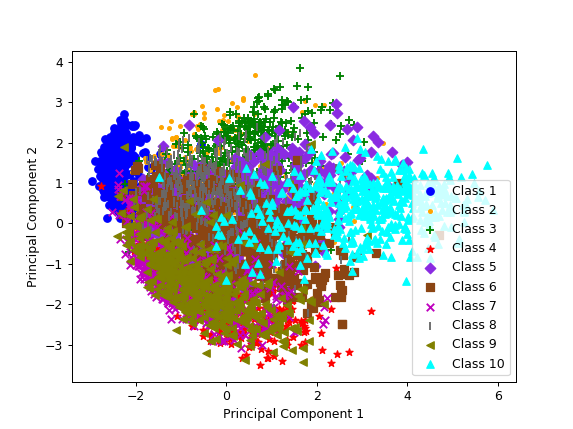

Plotting digits ... This may take few seconds ...


<IPython.core.display.Javascript object>


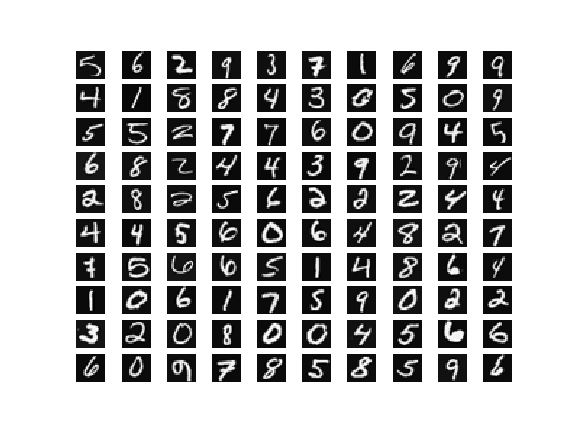

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.io import loadmat

filename = "datasets/digits-dataset.mat"


""" TODO:
Complete the following code to load the dataset from 
`filename` into variables X (inputs) and y (outputs).
"""
mat = loadmat(filename)
X = mat["X"]
y = mat["y"][0]
print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))


""" TODO:
Visualization: produce a 2d scatter plot of the data after applying PCA.
"""
markers = ["o",".","+","*","D","s","x","|","<", "^"]
colors = ["blue", "orange", "green","red","#8A2BE2", "#8B4513", "m","#696969","#808000", "cyan"]
pca = PCA(n_components=2)
fig, ax = plt.subplots()

pca.fit(X)
X_PCA = pca.transform(X)

for label, marker_color in enumerate(zip(markers, colors),1):
    digit = X_PCA[y==0 if label == 10 else y == label ]
    ax.scatter(digit[:,0], digit[:,1], marker=marker_color[0], color=marker_color[1], label=f'Class {label}')
    
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend()
fig.show()


""" TODO:
Read the following function then call it on the loaded input data X 
to visualize the original digits (each digit is a 20*20 image).
"""
def visualize_100_digits(X):
    # Pick 100 randomly chosen data-points and reshape them to 20*20 images.
    ids = np.random.choice(len(X), 100, replace=False)
    images = X[ids].reshape(100, 20, 20) # 100 images shaped as 20*20
    
    print("Plotting digits ... This may take few seconds ...")
    fig, axes = plt.subplots(10, 10)
    for i in range(10):
        for j in range(10):
            img = images[i*10+j].T
            axes[i][j].imshow( img, cmap='gray' )
            axes[i][j].axis("off")
    fig.show()

# TODO: call the function visualize_100_digits(X) here.
visualize_100_digits(X)


# 2. Neural Network
Our neural network is shown in the following figure:
<img src="imgs/NeuralNetwork.png" width="400px" />

This neural network has 3 layers: an input layer $a^{(1)}$, a hidden layer $a^{(2)}$ and an output layer $a^{(3)}$. It also has two matrices of parameters: $\Theta^{(1)}$ (connecting the two first layers), and $\Theta^{(2)}$ (connecting the two second layers).

Recall that our inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us $400$ input layer units (not counting the extra bias unit which is always $+1$). So, if we feed just **one data-point** $x \in \mathbb{R}^{400}$ to our input layer, then we should have $a^{(1)} \in \mathbb{R}^{401}$. However, if we stack **all our $n$ data-points** as columns into a matrix $X^T \in \mathbb{R}^{400 \times n}$ (i.e. transpose of the original $X$ matrix) and add the extra feature $x_0 = 1$ to each data-point (i.e. add a row of ones to $X^T$), then our input layer would be $a^{(1)} \in \mathbb{R}^{401 \times n}$.

Recall also that the number of classes we have is $K = 10$ classes and each of our class-labels $y^{(i)} \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$. In this multi-class classification problem, for each input vector $x$, the output layer $a^{(3)}$ should output a $K$ dimensional vector. Therefore, we should encode each of our class-labels $y^{(i)}$ (from $y$) as a **one-hot-vector** of dimension $K$. In other words, the labels vector $y$ of dimension $n$ should be encoded as a matrix $Y$ of dimension $K \times n$.

Also, remember that in this case, if the number of units in the hidden layer is $\text{hunits}$, then the first parameters matrix will be $\Theta^{(1)} \in \mathbb{R}^{\text{hunits} ~ \times ~ (400+1)}$, and the second parameters matrix will be $\Theta^{(2)} \in \mathbb{R}^{K ~ \times ~ (\text{hunits}+1)}$.

The general algorithm for training a neural network with 3 layers (i.e. with one hidden layer) can be summarized as follows. The most important parts of the algorithm are the **feedforward** and **backpropagation** that you will implement in the next sections. Please read and understand the following general code:

```python
def neural_network_training(X, y, max_iterations=1000, alpha=1e-3, hunits=25):
    a1 = add_row_ones(X.T)    # create an input layer of dimension (401 * n)
    Y = vectorize_outputs(y) # encode the labels vector y as a matrix Y of dimension (K * n)
    
    # Generating randomly the initial weights (parameters values)
    Theta1 = np.random.randn(hunits, a1.shape[0])   # Parameters matrix of dimension (hunits * 401)
    Theta2 = np.random.randn(Y.shape[0], hunits+1)  # Parameters matrix of dimension K * (hunits+1)
    
    # Iterative optimization of the parameters
    for itr in range(max_iterations):
        z2, a2, z3, a3 = feedforward(a1, Theta1, Theta2) # Feedforward propagation
        DELTA1, DELTA2 = backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2) # Backpropagation
        
        # Update the parameters using gradient descent
        Theta1 = Theta1 - alpha * DELTA1
        Theta2 = Theta2 - alpha * DELTA2
        
    return Theta1, Theta2
```

## 2.1 Some Useful Functions
Before proceeding, we first provide in this section some useful functions.

The first function is `add_row_ones(A)`. It takes a given matrix `A` (two dimensional numpy array) and returns a new matrix based on `A` with an additional first row of ones. This will be helpful later, for example, when you want to feed the data to the input layer. Remember that $X \in \mathbb{R}^{d \times n}$ (in our digits dataset $d=400, n=5000$) and $a^{(1)} \in \mathbb{R}^{(d+1) \times n}$. So, to feed the dataset to the input layer, we can transpose $X$ and add a row of ones to it: `add_row_ones(X.T)` (which would be in $\mathbb{R}^{(d+1) \times n}$).

The second function is `vectorize_outputs(y)`. It takes an array of class-labels $y$ and returns a matrix $Y$ where the $i^{th}$ column in $Y$ corresponds to the one-hot-vector of the $i^{th}$ class-label $y^{(i)}$ in $y$. This will be helpful later when we want to compare the output of the last layer $a^{(3)} \in \mathbb{R}^{K \times n}$ to the true output $Y  \in \mathbb{R}^{K \times n}$.

The third function is `sigmoid(z)`. It computes the sigmoid defined as: $\text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}}$. This function works when the argument $z$ is a scalar value, a vector, or a matrix. For a vector or a matrix, the function will perform the sigmoid function on every element. This function will be useful later on when you implement feedforward and backpropagation.

The forth function is `sigmoid_deriv(z)` which is the derivative of the sigmoid function defined as: $\frac{\partial}{\partial z} g(z) = g(z) (1 - g(z))$. This function works when the argument $z$ is a scalar value, a vector, or a matrix. For a vector or a matrix, the function will apply the derivative on every element. This function will be useful later on when you implement backpropagation.

You don't have to implement anything in this section. Just read the code before running it to understand what each function does.

**Important Note:** In this lab we are using the sigmoid function as an activation function for our hidden layer just for an educational purpose. However, you should be aware that it is usually **not** a good idea to use the sigmoid activation function for the hidden layers (especially if you have several hidden layers), as it may suffer from the **vanishing gradient problem**. In reality, it is usually better to use a simpler activation function such as ReLU (Rectified Linear Unit) and have more hidden layers. For more information about this topic, please read: https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

In [2]:
"""
This function returns a new matrix based on A with an 
additional first row of ones. """
def add_row_ones(A):
    row_ones = np.ones((1, A.shape[1]))
    return np.append(row_ones, A, axis=0)


"""
This function returns a (K * n) matrix where the i'th column is the 
one-hot-vector corresponding to the i'th class-label in y. """
def vectorize_outputs(y):
    K = len(set(y)) # number of unique classes
    return np.eye(K)[y].T


"""
This function computes the sigmoid. The argument z can be a 
scalar value, a vector, or a matrix.
"""
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


"""
This function computes the gradient of the sigmoid function. 
The argument z can be a scalar value, a vector, or a matrix.
"""
def sigmoid_deriv(z):
    return sigmoid(z) * (1 - sigmoid(z))


""" TODO:
The following code test the functions defined above on some simple
examples. Run it to test it and understand what these functions do.
"""
result = add_row_ones(
    np.array([
        [1, 2,  3,  4], 
        [5, 6,  7,  8], 
        [9, 10, 11, 12]])
)
print("\n add_row_ones(...) \n", result)

arr = np.array([2, 0, 2, 3, 1, 1])
result = vectorize_outputs(arr)
print("\n vectorize_outputs(...) corresponding to {} is:\n {}".format(arr, result))

result = sigmoid( np.array([-2, -1, 0, 1, 2]) )
print("\n sigmoid(...) \n", result)

result = sigmoid_deriv( np.array([-5, -2, -1, 0, 1, 2, 5]) )
print("\n sigmoid_deriv(...) \n", result)



 add_row_ones(...) 
 [[ 1.  1.  1.  1.]
 [ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]]

 vectorize_outputs(...) corresponding to [2 0 2 3 1 1] is:
 [[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]

 sigmoid(...) 
 [0.11920292 0.26894142 0.5        0.73105858 0.88079708]

 sigmoid_deriv(...) 
 [0.00664806 0.10499359 0.19661193 0.25       0.19661193 0.10499359
 0.00664806]


# 3. Feedforward Propagation, Prediction and Cost Function
In this section, you have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in `ANNweights.mat` and are loaded in the following Python code into matrices `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with $\text{hunits}=25$ hidden units in the second layer and $K=10$ output units (corresponding to the 10 digit classes).

<img src="imgs/neuralNetWorkArch.png" width="400px" />

Run the following Python code to load the provided parameters $\Theta^{(1)}$ and $\Theta^{(2)}$. The rows in the matrices `Theta1` and `Theta2` correspond to the parameters of each unit. For example, the first row of `Theta1` corresponds to the first hidden unit in the second layer.

In [3]:
mat = loadmat("datasets/ANNweights.mat")

Theta1 = mat["Theta1"]
Theta2 = mat["Theta2"]

print("Theta1.shape: {}, Theta2.shape: {}".format(Theta1.shape, Theta2.shape))

Theta1.shape: (25, 401), Theta2.shape: (10, 26)


## 3.1. Feedforward Propagation
Now you will implement feedforward propagation for the neural network. You should implement the feedforward computation that computes the output $a^{(3)} \in \mathbb{R}^{K, n}$ for all examples in our training set $X$ at once. To do so, the input `a1` (first argument of the function `feedforward(a1, Theta1, Theta2)`) is expected to be an array of shape `(d+1, n))`, i.e. `(401, 5000)` for our digits dataset.

Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \geq 3$ labels).

Before starting to implement the function `feedforward(..)`, read the full Python code below. Particularly, notice at the end of the code that the input is prepared for you as `a1 = add_row_ones(X.T)` before calling the function `feedforward(..)`.


In [6]:
""" TODO:
First, read the full Python code of this cell. Then, write 
the definition of the function feedforward(...) below.
"""
def feedforward(a1, Theta1, Theta2):
    pass
    # TODO: compute z2 as explained in the figure above.
    z2 = Theta1@a1
    # TODO: compute a2 as explained in the figure above.
    a2 = sigmoid(z2)
    # TODO: add a row of ones to a2 as explained in the figure above.
    a2 = add_row_ones(a2)
    # TODO: compute z3 as explained in the figure above.
    z3 = Theta2@a2
    # TODO: compute a3 as explained in the figure above.
    a3 = sigmoid(z3)
    # TODO: uncomment the next line to return the results (z2, a2, z3, a3)
    return z2, a2, z3, a3


""" TODO:
Uncomment the following code and read it. It calls your function feedforward(...) 
and check the output corresponding to the first data-point in the training set. 
The predicted class-label for this first data-point should be 0.
"""

##### Uncomment the following code:

a1 = add_row_ones(X.T)   # We create the input a1 of dimension ((d+1) * n)
print("Shapes: X: {}, a1: {}, y: {}, Theta1: {}, Theta2: {}"
      .format(X.shape, a1.shape, y.shape, Theta1.shape, Theta2.shape))

ffresults = feedforward(a1, Theta1, Theta2)

# The last element returned from feedforward(..) is a3
a3 = ffresults[-1]
print("a3.shape: {}\n".format(a3.shape))

# The first column in a3 is the predicted output (as a vector of dim K=10) corresponding of the first data-point
arr = a3[:, 0]
print("*** Output corresponding to the first data-point:\n", arr)
print("*** The corresponding predicted class-label (for the first data-point) is:", np.argmax(arr))



Shapes: X: (5000, 400), a1: (401, 5000), y: (5000,), Theta1: (25, 401), Theta2: (10, 26)
a3.shape: (10, 5000)

*** Output corresponding to the first data-point:
 [9.99634467e-01 1.24468845e-06 3.88789472e-04 3.20959468e-04
 7.96742710e-07 5.32264192e-04 1.97184774e-04 4.41761567e-04
 2.24608757e-05 5.60473860e-05]
*** The corresponding predicted class-label (for the first data-point) is: 0


## 3.2 Predicting class-labels
Once you have implemented and tested the `feedforward(a1, Theta1, Theta2)` function, you will complete the Python code below to implement the function `predict(X, Theta1, Theta2)`.

This function should take a dataset $X \in \mathbb{R}^{n \times d}$, create an input $a^{(1)} \in \mathbb{R}^{(d+1) ~ \times ~ n}$ based on $X$, perform a feedforward propagation to get the outputs $a^{(3)} \in \mathbb{R}^{K \times n}$ from the neural network, and finally return the corresponding predicted class-labels. Note that the column $i$ from $a^{(3)}$ corresponds to the output $h_\Theta(x^{(i)})$ of data-point $x^{(i)}$. The predicted class-label for this data-point is the label that has the largest output $(h_\Theta(x^{(i)}))_k$

Once you are done, the code will call your `predict(..)` function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy on the training set is about $98.6\%$.

In [39]:
""" TODO:
Write the definition of the predict(..) function which takes a new dataset X, the 
parameters Theta1 and Theta2, and returns the predicted classes for the data-points in X. 
In other words, the function should return an array of n predicted class-labels.
"""
def predict(X, Theta1, Theta2):
    a1 = add_row_ones(X.T)
    ffresults = feedforward(a1, Theta1, Theta2)
    a3 = ffresults[-1]
    predictions = a3[:,0]
    return [np.argmax(column) for column in a3.T]

""" TODO:
Uncomment the lines below to test your function predict(..) on the training 
data X. If you implemented the functions predict(..) and feedforward(..) 
correctly, then you should see a training accuracy of about 98.6%.
"""
y_pred = predict(X, Theta1, Theta2)
print("Accuracy: ", (y == y_pred).mean() * 100)

Accuracy:  98.61999999999999


## 3.3 Cost Function
Now you need to complete the following Python code to implement the cost function `E_unregularized(...)`. Recall that the cost function for the neural network (without regularization) is
$$
E(\Theta) = \frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} \left [ -y_k^{(i)} \log{( (h_\Theta(x^{(i)}))_k )} - (1 - y_k^{(i)}) \log{( 1 - (h_\Theta(x^{(i)}))_k )} \right ], 
$$
where $h_\Theta(x^{(i)})$ is computed as shown in the previous figure (of the ANN architecture) and $K = 10$ is the total number of possible labels. Note that $h_\Theta(x^{(i)})_k$ is the output value (in the last layer) of the $k^{th}$ output unit for data-point $x^{(i)}$. Also, recall that whereas the original labels (in the variable $y$) were $1, 2, \dots, 10$, for the purpose of training a neural network we need to recode the labels as vectors containing only values $0$ or
$1$ (i.e. one-hot-vectors), so that
$$
y^{(i)} = 
\begin{bmatrix}
1\\ 
0\\ 
0\\ 
\vdots \\
0 
\end{bmatrix}, \quad
\begin{bmatrix}
0\\ 
1\\ 
0\\ 
\vdots \\
0 
\end{bmatrix}, \quad
\dots, \text{ or } \quad
\begin{bmatrix}
0\\ 
0\\ 
0\\ 
\vdots \\
1 
\end{bmatrix}
$$
For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y^{(i)}_5 = 1$, and the other elements equal to $0$. This kind of encoding is called "*one hot vector*" encoding. The following Python code calls the function `vectorize_outputs(y)` which encodes for you the original vector of labels $y$ (of dimension $n$) into a matrix $Y$ (of dimension $K \times n$).

Once you are done, call your `E_unregularized(..)` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about $0.15835$.

In [64]:
# Encoding the class-labels as one hot vectors
Y = vectorize_outputs(y)


""" TODO:
Write the definition of the cost function E(..) for the specified neural network.
"""
def E_unregularized(X, Y, Theta1, Theta2):
    # TODO: Prepare the neural network input a1 based on X
    a1 = add_row_ones(X.T)
    # TODO: Perform a feedforward propagation to get the outputs
    ffresults = feedforward(a1, Theta1, Theta2)
    a3 = ffresults[-1].T
    print(a3.shape)
    #predictions = [np.argmax()]
    predictions = predict(X, Theta1, Theta2)
    n = len(Y)
    
    #print(predictions.T)
    # TODO: Compute the (unregularized) cost indicated in the previous formula.
    return (1/n)*(-Y.T@np.log(predictions)-(1-Y.T)@np.log(1-predictions))


""" TODO:
Call your cost function E_unregularized using the training set X, Y and the loaded parameters 
Theta1 and Theta2. If your implementation is correct, you should see a cost of about 0.15835
"""
print(Y.T)
cost = E_unregularized(X, Y, Theta1, Theta2)
print("Unregularized cost:", cost)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(5000, 10)


<ipython-input-64-c4fb5280d7e4>:21: RuntimeWarning: divide by zero encountered in log
  return (1/n)*(-Y.T@np.log(predictions)-(1-Y.T)@np.log(1-predictions))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5000 is different from 10)

You will now implement the cost function for neural networks with regularization. This regularized cost is given by
$$
E(\theta) = \frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} \left [ -y_k^{(i)} \log{( (h_\theta(x^{(i)}))_k )} - (1 - y_k^{(i)}) \log{( 1 - (h_\theta(x^{(i)}))_k )} \right ] + \frac{\lambda}{2n} \left [ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \right ]. 
$$

You can assume that the neural network will only have 3 layers: an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that **your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size**.

Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $E$ using your existing `E_unregularized(..)` and then later add the cost for the regularization terms.

Once you are done, call your function `E_regularized(..)` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about $1.37917$.

In [ ]:
""" TODO:
Write the definition of the regularized cost function for the specified neural network.
"""
def E_regularized(X, Y, Theta1, Theta2, lmd):
    ...
    # return ...


""" TODO:
Call your cost function E_regularized using the training set X, Y and the loaded parameters 
Theta1 and Theta2. If your implementation is correct, you should see a cost of about 1.37917
"""
# cost = E_regularized(X, Y, Theta1, Theta2, lmd = 1)
# print("Regularized cost", cost)


# 4. Backpropagation
In the previous sections, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the parameters (weights) we provided. In this section, you will implement the backpropagation algorithm to learn the parameters for the neural network. The backpropagation algorithm allows to compute the gradient for the neural network cost function. You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $E(\theta)$ using a simple optimization procedure such as gradient descent.

## 4.1 Backpropagation without Regularization
<img src="imgs/BackpropagationNNArchitecture.png" width="400px" />

Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a "*forward pass*" to compute all the activations throughout the network, including the output value of the hypothesis $h_\Theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "*error term*" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$, as depicted in the above figure.

In more details, here is how the neural network training works:

1. In the function `neural_network_training(..)` given below, we encode $y$ (the true class-labels) as a matrix $Y$ (as explained previously); we use the input data $X \in \mathbb{R}^{n ~ \times ~ d}$) to set our input layer `a1` $\in \mathbb{R}^{(d+1) ~ \times ~ n}$; then, we initialize the parameters matrices `Theta1` and `Theta2` randomly.

2. We iterate several times with a loop `for itr in range(max_iterations): ...` until convergence or until we reach `max_iterations`. At each iteration we do the following:
  1. We perform a feedforward propagation pass in order to compute the activations $(z^{(2)}, a^{(2)}, z^{(3)}; a^{(3)})$ for layers 2 and 3 using our previously defined function: `z2, a2, z3, a3 = feedforward(a1, Theta1, Theta2)`.
  2. We perform a backpropagation pass in order to compute the gradients `D1` and `D2`, using the backpropagation function defined below: `D1, D2 = backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2)`.
  3. We perform a gradient descent step to update the matrices parameters `Theta1` and `Theta2`.
  

The backpropagation function `backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2)` is given to you in the following code. You are asked to read it and understand how it works. Here is some explanation to help you better understand it:
1. First, we compute the erros (`delta3`) at the output layer as follows: $\delta^{(3)} = (a^{(3)} - Y)$. This is possible since $a^{(3)} \in \mathbb{R}^{K ~ \times ~ n}$ and $Y \in \mathbb{R}^{K ~ \times ~ n}$ are of the same dimensions.

2. For layer 2 (our hidden layer), we first need to compute $(\Theta^{(2)})^T \delta^{(3)}$. Notice that $\Theta_2 \in \mathbb{R}^{K ~ \times ~ (\text{hunits+1})}$ and $\delta^{(3)} \in \mathbb{R}^{K ~ \times ~ n}$, so the product $(\Theta^{(2)})^T \delta^{(3)}$ is possible and the result `result_temp = (Theta2.T @ delta3)` will be in $\mathbb{R}^{(\text{hunits+1}) ~ \times ~ n}$. Next, we ignore the first row from this result as it is associated with the additional bias unit: `result_temp = result_temp[1:]`. Then, we need to elementwise-multiply this result with $g'(z^{(2)})$, where $g'(.)$ is the derivative of the activation function (i.e. `sigmoid_deriv(z2)`). This is done with `delta2 =  result_temp * sigmoid_deriv(z2)`. Note that this elementwise multiplication is possible as $g'(z^{(2)}) \in \mathbb{R}^{\text{hunits} ~ \times ~ n}$. Also, note that there is no $\delta^{(1)}$ to compute, as layer 1 corresponds to our input data (which does not change).

3. Finally, the (unregularized) gradients $\frac{\partial}{\partial \Theta_{ij}^{(l)}} E(\Theta)$ with respect to the parameters of $\Theta^{(l)}$ are obtained in $\Delta^{(l)}$ (which is of the same dimensions as $\Theta^{(l)}$) using the formula: $$\Delta^{(l)} = \frac{1}{n} \big [ \delta^{(l+1)} (a^{(l)})^T \big ].$$ In the code below, `DELTA1` corresponds to $\Delta^{(1)}$, and `DELTA2` corresponds to $\Delta^{(2)}$.


In [ ]:
""" TODO:
Read the definition of the backpropagation function and run this cell.
"""
def backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2):
    delta3 = 2 * (a3 - Y)
    
    result_temp = (Theta2.T @ delta3)
    result_temp = result_temp[1:] # we ignore the first row
    delta2 =  result_temp * sigmoid_deriv(z2)
    
    n = a1.shape[1]
    
    DELTA2 = (1/n) * (delta3 @ a2.T)
    DELTA1 = (1/n) * (delta2 @ a1.T)
    
    return DELTA1, DELTA2


Once we defined the backpropagation algorithm (to compute the gradients), we will use it below to train the neural network and compute its training accuracy. This will allow you to increase your confidence that your code is computing the gradients correctly. The function `neural_network_training(..)` in the following Python code, uses your functions `feedforward(..)` and `backpropagation(..)` to train the neural network (i.e. learn its parameters). Read the code and then run it to test your backpropagation implementation. If your implementation was correct, then you should expect a training accuracy of more than $95\%$ when `neural_network_training(..)` is called with `max_iterations = 2000` (iterations of gradient descent), `alpha = 0.5` (learning rate of gradient descent), and `hunits = 25` (units in the hidden layer).

In [ ]:
"""
This function calls your function feedforward(..) 
and backpropagation(..) to train the neural network.
"""
def neural_network_training(X, y, max_iterations=2000, alpha=0.5, hunits=25):
    Y = vectorize_outputs(y)
    a1 = add_row_ones(X.T)
    
    # Random initialization of the parameters
    Theta1 = np.random.randn(hunits, a1.shape[0])
    Theta2 = np.random.randn(Y.shape[0], hunits+1)
    
    for itr in range(max_iterations):
        # Feedforward and backpropagation to obtain the gradients
        z2, a2, z3, a3 = feedforward(a1, Theta1, Theta2)
        D1, D2 = backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2)
        
        # Using gradient descent to update the parameters
        Theta1 = Theta1 - alpha * D1
        Theta2 = Theta2 - alpha * D2
        
        if itr % 50 == 0:
            print("itr = {}, cost = {}".format(itr, E_unregularized(X, Y, Theta1, Theta2)), end="\r")
    return Theta1, Theta2


"""
We call the above function to train the neural network (learn the parameters), 
then we predict the labels for the training set X and compute the accuracy on 
the training set. You should expect a training accuracy of more than 95%.
"""
Theta1, Theta2 = neural_network_training(X, y, max_iterations=2000, alpha=0.5, hunits=25)
y_pred = predict(X, Theta1, Theta2)
print("Accuracy: ", (y == y_pred).mean() * 100)


## 4.2 Regularized Neural Networks
After you have successfully run the previous algorithm, you will now add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta^{(l)}_{ij}$ using backpropagation, you should add regularization using

$$
\frac{\partial}{\partial \Theta^{(l)}_{ij}} E(\Theta) = \Delta^{(l)}_{ij} \quad \quad \quad \quad \quad \text{ for } j = 0
$$

$$
\frac{\partial}{\partial \Theta^{(l)}_{ij}} E(\Theta) = \Delta^{(l)}_{ij} + \frac{\lambda}{n} \Theta^{(l)}_{ij} \quad \quad \text{ for } j \geq 1
$$
Note that we do not regularize the first column (i.e. where $j=0$) which is used for the bias term.

Your task is to modify the function `neural_network_training(..)` in the Python code below to account for regularization. Note that the function now has an additional argument `lmd` which corresponds to the regularization hyperparameter $\lambda$.

With $\lambda = 20$, you should be getting a training accuracy which is smaller than previously (the unregularized case, or when $\lambda=0$). However, this DOES NOT necessarily mean that your neural network is now worse. Why? You are asked to answer this question *inside* the last comment in the code below.

In [ ]:
"""
This function calls your functions feedforward(..) 
and backpropagation(..) to train the neural network.
"""
def neural_network_training(X, y, max_iterations=2000, alpha=0.5, hunits=25, lmd=20):
    Y = vectorize_outputs(y)
    a1 = add_row_ones(X.T)
    
    # Random initialization of the parameters
    Theta1 = np.random.randn(hunits, a1.shape[0])
    Theta2 = np.random.randn(Y.shape[0], hunits+1)
    
    for itr in range(max_iterations):
        # Feedforward and backpropagation to obtain the gradients
        z2, a2, z3, a3 = feedforward(a1, Theta1, Theta2)
        D1, D2 = backpropagation(a1, z2, a2, z3, a3, Y, Theta1, Theta2)
        
        """ TODO:
        Modify D1 and D2 here to account for regularization.
        """
        # ...
        # ...
        
        # Using gradient descent to update the parameters
        Theta1 = Theta1 - alpha * D1
        Theta2 = Theta2 - alpha * D2
        
        if itr % 50 == 0:
            print("itr = {}, cost = {}".format(itr, E_regularized(X, Y, Theta1, Theta2, lmd)), end="\r")
            
    return Theta1, Theta2


"""
We call the above function to train the neural network (learn the parameters), 
then we predict the labels for the training set X and compute the accuracy on 
the training set. You should expect a training accuracy of less than 95%.
"""
Theta1, Theta2 = neural_network_training(X, y, max_iterations=2000, alpha=0.5, hunits=25, lmd=20)
y_pred = predict(X, Theta1, Theta2)
print("Accuracy: ", (y == y_pred).mean() * 100)


""" TODO:
Write inside this comment HERE (not outside) your answer to the following question:

Question: Why your regularized neural network is considered to be better than the 
unregularized one (i.e. lambda = 0), even though the training accuracy that you 
achieve with the unregularized one is higher?

WRITE YOUR (SHORT) ANSWER HERE:
... ... ... ...
... ... ... ...
"""

## 5 Visualizing the hidden layer
One way to understand what your neural network is learning is to visualize what are the representations captured by the hidden units (units of the hidden layer). Informally, given a particular hidden unit, one way to visualize what it computes is to find an
input $x$ that will cause it to activate (that is, to have a sigmoid activation value $a^{(l)}_{i}$ close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a vector of dimension 401 that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the "*representation*" captured by the hidden unit is to reshape this 400 dimensional vector into a $20 \times 20$ image and display it. The following Python code does this and show you an image (similar to the following figure) with 25 units, each corresponding to one hidden unit in the network.

In your trained network, you should find that the hidden units correspond roughly to detectors that look for strokes and other patterns in the input.

<img src="imgs/vizUnitsNN.png" width="400px" title="Visualization of Hidden Units" alt="Visualization of Hidden Units" />

In [ ]:
def visualize_hidden_units(Theta1, Theta2):
    # Reshape Theta1 into 25 images of shape 20*20
    images = Theta1[:, 1:].reshape((25, 20, 20))

    # Plot with a grid of 5*5 = 25 images
    fig, axes = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            img = images[i*5+j].T
            axes[i][j].imshow( img, cmap='gray' )
            axes[i][j].axis("off")
    fig.show()


# Training the neural network with max_iterations=2000, alpha=0.5, hunits=25, lmd=20
Theta1, Theta2 = neural_network_training(X, y, max_iterations=2000, alpha=0.5, hunits=25, lmd=20)

# We call our above function to visualize the 25 hidden units as 20*20 images.
visualize_hidden_units(Theta1, Theta2)


### B.3.1 Trying various values of $\lambda$ and `max_iterations`

In this section, you will get to try out different learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and the number of training steps (the `max_iterations` argument in the function `neural_network_training(..)`).

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to "overfit" a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. You can set the regularization $\lambda$ to a smaller value and the `max_iterations` argument to a higher number of iterations to see this for youself.

You will also be able to see for yourself the changes in the visualizations of the hidden units when you change the learning parameters $\lambda$ and `max_iterations`.

In [ ]:
# TODO: train the ANN using some values of max_iterations and lmd.
# TODO: visualize the hidden units based on the parameters you got.

# TODO: train the ANN using some other values of max_iterations and lmd.
# TODO: visualize the hidden units based on the parameters you got.

# TODO: train the ANN using some other values of max_iterations and lmd.
# TODO: visualize the hidden units based on the parameters you got.

# ...
# ...
